In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

### Ejercicio 1

In [113]:
datos = pd.read_excel('wind_data.xlsx')
print(datos)

       dia  regional wind  wind gap norte sur
0        1       8.000000            0.000000
1        2       8.346296            0.181523
2        3      10.062316            0.188643
3        4      10.791337            0.071085
4        5      10.754093            0.078442
...    ...            ...                 ...
3645  3646       8.642231           -0.869425
3646  3647       6.527408           -1.268447
3647  3648       6.230707           -1.149234
3648  3649       5.550882           -0.420431
3649  3650       6.545450            0.250088

[3650 rows x 3 columns]


In [114]:
datos['wind dif'] = datos['regional wind'].diff().shift(-1) #Si+1 - Si
print(datos)

       dia  regional wind  wind gap norte sur  wind dif
0        1       8.000000            0.000000  0.346296
1        2       8.346296            0.181523  1.716019
2        3      10.062316            0.188643  0.729021
3        4      10.791337            0.071085 -0.037244
4        5      10.754093            0.078442  0.017364
...    ...            ...                 ...       ...
3645  3646       8.642231           -0.869425 -2.114824
3646  3647       6.527408           -1.268447 -0.296701
3647  3648       6.230707           -1.149234 -0.679825
3648  3649       5.550882           -0.420431  0.994568
3649  3650       6.545450            0.250088       NaN

[3650 rows x 4 columns]


In [115]:
#datos_filtrados = datos.dropna(subset=['wind dif'])
datos['theta'] = 6 + 2 * np.cos(2 * np.pi * datos['dia'] / 365)

# Calcular theta(t_i) - S_i
datos['theta_minus_S'] = datos['theta'] - datos['regional wind']
data_filtrada = datos.dropna(subset=['wind dif', 'theta_minus_S'])

slope, intercept, r_value, p_value, std_err = stats.linregress(data_filtrada['theta_minus_S'], data_filtrada['wind dif'])

beta_1 = slope
beta_0 = intercept

print('beta_0:', beta_0)
print('beta_1:', beta_1)
print('std_err:', std_err)

beta_0: -0.01090490726175827
beta_1: 0.29874316789949523
std_err: 0.01177072911949767


In [116]:
kappa = (365 * beta_1)
print('kappa:', kappa)

kappa: 109.04125628331576


In [117]:
# Calcular los residuos
residuos = data_filtrada['wind dif'] - (slope * data_filtrada['theta_minus_S'] + intercept)

# Calcular el error estándar de los residuos
residual_std_err = np.std(residuos, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_std_err)
# Calcular sigma
sigma = residual_std_err * np.sqrt(365)
print('sigma:', sigma)

residual_std_err: 0.8399264390386392
sigma: 16.046772086422457


In [118]:
datos['gap dif'] = datos['wind gap norte sur'] - datos['wind gap norte sur'].shift(1)
print(datos)

       dia  regional wind  wind gap norte sur  wind dif     theta  \
0        1       8.000000            0.000000  0.346296  7.999704   
1        2       8.346296            0.181523  1.716019  7.998815   
2        3      10.062316            0.188643  0.729021  7.997334   
3        4      10.791337            0.071085 -0.037244  7.995261   
4        5      10.754093            0.078442  0.017364  7.992596   
...    ...            ...                 ...       ...       ...   
3645  3646       8.642231           -0.869425 -2.114824  7.995261   
3646  3647       6.527408           -1.268447 -0.296701  7.997334   
3647  3648       6.230707           -1.149234 -0.679825  7.998815   
3648  3649       5.550882           -0.420431  0.994568  7.999704   
3649  3650       6.545450            0.250088       NaN  8.000000   

      theta_minus_S   gap dif  
0         -0.000296       NaN  
1         -0.347482  0.181523  
2         -2.064982  0.007120  
3         -2.796076 -0.117558  
4         -

In [119]:
datos_filtrados_gap = datos.dropna(subset=['gap dif'])

slope_gap, intercept_gap, r_value_gap, p_value_gap, std_err_gap = stats.linregress(datos_filtrados_gap['wind gap norte sur'], datos_filtrados_gap['gap dif'])

beta_1_gap = slope_gap
beta_0_gap = intercept_gap

print('beta_0:', beta_0_gap)
print('beta_1:', beta_1_gap)

beta_0: -0.004013223850057093
beta_1: 0.1325505861738276


In [120]:
beta = 365 * beta_1_gap
beta

48.38096395344707

In [121]:
# Calcular los residuos
residuos_gap = datos_filtrados_gap['gap dif'] - (slope_gap * datos_filtrados_gap['wind gap norte sur'] + intercept_gap)

# Calcular el error estándar de los residuos
residual_gap_std_err = np.std(residuos_gap, ddof=1)  # ddof=1 para usar n-1 en la fórmula de la desviación estándar
print('residual_std_err:', residual_gap_std_err)
# Calcular sigma
gamma = residual_gap_std_err * np.sqrt(365)
print('gamma:', gamma)

residual_std_err: 0.5282417805574243
gamma: 10.092045047222316


## Ejercicio 2

In [122]:
def theta(t):
    return 6 + 2 * np.cos(2 * np.pi * t / 365)

In [123]:
def simulacion (n_days):
    S = np.zeros(n_days)
    D = np.zeros(n_days)

    # Valores iniciales (suponemos que S_0 y D_0 son conocidos o se dan como 0)
    S[0] = np.mean(datos['regional wind'])
    D[0] = 0

    for i in range(1, n_days):
        S[i] = S[i - 1] + kappa * (theta(i) - S[i - 1]) * 1/365 + sigma * np.sqrt(1/365) * np.random.normal(0, 1)
            
        D[i] = D[i-1] - beta * D[i-1] * 1/365 + gamma * np.sqrt(1/365) * np.random.normal(0, 1)

    return S, D

In [227]:
S, D = simulacion(3650)

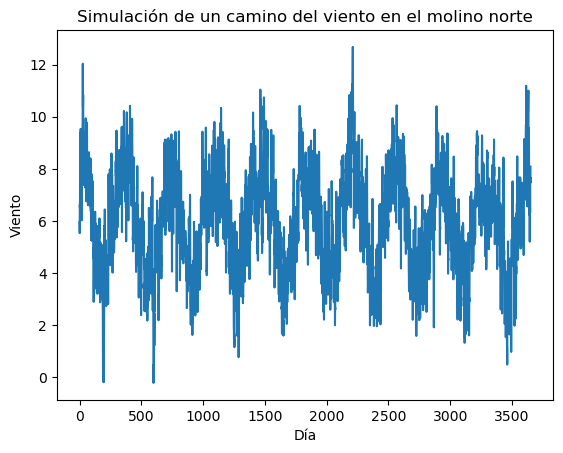

In [232]:
#Viento en molino norte
S_norte = S+D/2

plt.plot(S_norte)
plt.title('Simulación de un camino del viento en el molino norte')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

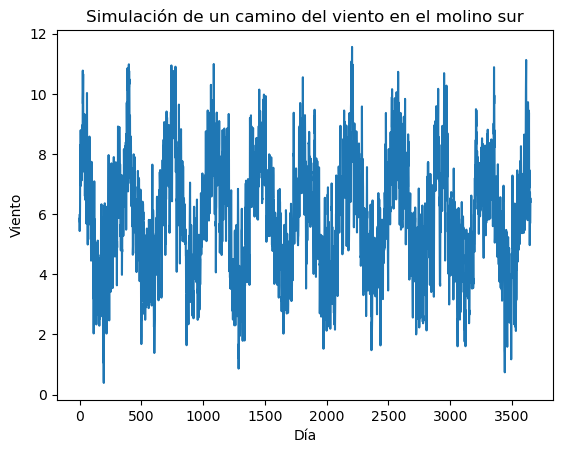

In [233]:
S_sur = S-D/2

plt.plot(S_sur)
plt.title('Simulación de un camino del viento en el molino sur')
plt.xlabel('Día')
plt.ylabel('Viento')
plt.show()

Media del viento simulado: 5.968323302670129
Desviación estándar del viento simulado: 1.82573774164269
Media del viento histórico: 5.964442822277723
Desviación estándar del viento histórico: 1.8032133987250791
Media de la diferencia simulada: 0.07270143169465647
Desviación estándar de la diferencia simulada: 1.048452246256521
Media de la diferencia histórica: 0.03078554102481403
Desviación estándar de la diferencia histórica: 1.0614721182882032


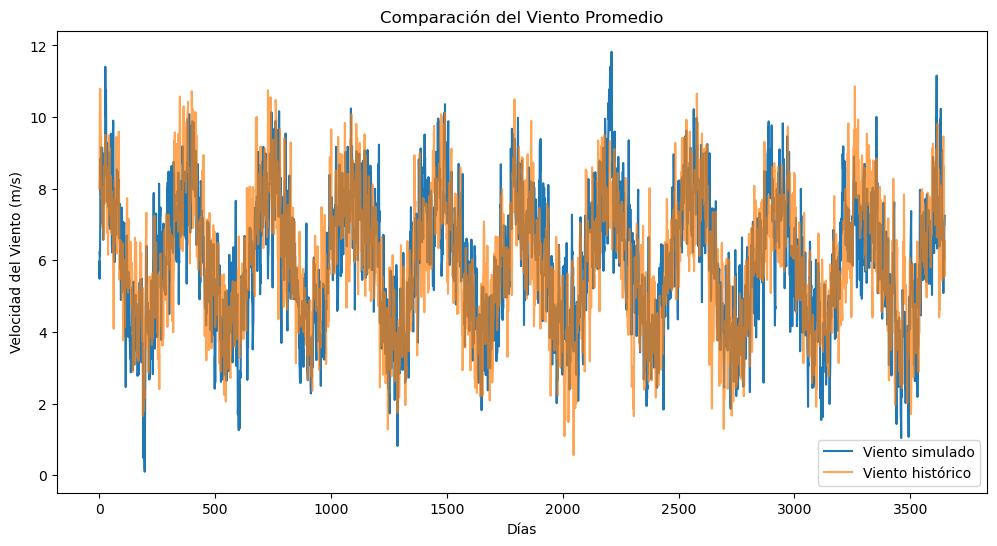

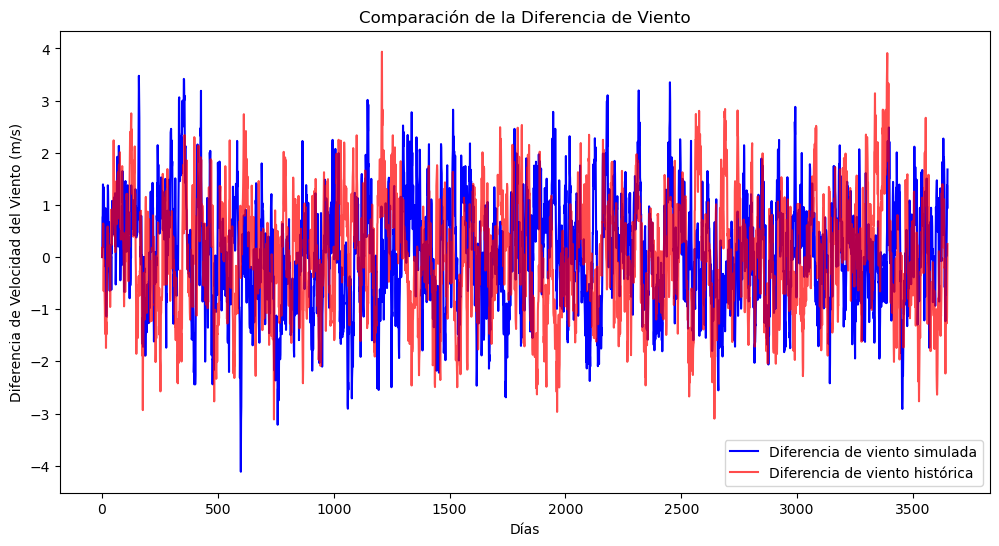

In [234]:
# Supongamos que tienes datos históricos de 'wind' y 'wind dif'
historical_wind = datos['regional wind']
historical_wind_dif = datos['wind gap norte sur']

# Comparación de la media y desviación estándar
print(f"Media del viento simulado: {np.mean(S)}")
print(f"Desviación estándar del viento simulado: {np.std(S)}")
print(f"Media del viento histórico: {np.mean(historical_wind)}")
print(f"Desviación estándar del viento histórico: {np.std(historical_wind)}")

# Similar para la diferencia de viento
print(f"Media de la diferencia simulada: {np.mean(D)}")
print(f"Desviación estándar de la diferencia simulada: {np.std(D)}")
print(f"Media de la diferencia histórica: {np.mean(historical_wind_dif)}")
print(f"Desviación estándar de la diferencia histórica: {np.std(historical_wind_dif)}")

# Gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(S, label='Viento simulado')
plt.plot(historical_wind, label='Viento histórico', alpha=0.7)
plt.title('Comparación del Viento Promedio')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(D, label='Diferencia de viento simulada', color='blue')
plt.plot(historical_wind_dif, label='Diferencia de viento histórica', color='red', alpha=0.7)
plt.title('Comparación de la Diferencia de Viento')
plt.xlabel('Días')
plt.ylabel('Diferencia de Velocidad del Viento (m/s)')
plt.legend()
plt.show()


## Ejercicio 3


In [235]:
def calcular_VAN(S, D, k, n_days, costo_rep):
    cashflow = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    apagados_norte = np.zeros(n_days)
    apagados_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= costo_rep  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= costo_rep  # Costo de reparación

        if viento_norte[i] > k:
            estado_molino_norte[i] = 0 #si pasa umbral se apaga
            apagados_norte[i] = 1
            cashflow[i] -= 1000  # Costo de apagar el molino
        elif  viento_norte[i] <= k:
            estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if viento_sur[i] > k:
            estado_molino_sur[i] = 0
            apagados_sur[i] = 1
            cashflow[i] -= 1000  # Costo de apagar el molino
        elif viento_sur[i] <= k:
            estado_molino_sur[i] = 1

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN_calc = np.sum(cashflow * descuentos)

    return VAN_calc, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur, apagados_norte, apagados_sur

In [239]:
S, D = simulacion(365)

VAN_calculado, cashflow, estado_molino_norte, estado_molino_sur, roturas_molino_norte, roturas_molino_sur, apagados_molino_norte, apagados_molino_sur = calcular_VAN(S, D, 10, 365, 200000)
print(f"El Valor Actual Neto (VAN) del proyecto es: {VAN_calculado:.2f}")
print(f"Número de roturas del molino norte: {np.sum(roturas_molino_norte)}")
print(f"Número de roturas del molino sur: {np.sum(roturas_molino_sur)}")
print(f"Número de apagados del molino norte: {np.sum(apagados_molino_norte)}")
print(f"Número de apagados del molino sur: {np.sum(apagados_molino_sur)}")


El Valor Actual Neto (VAN) del proyecto es: 1880626.10
Número de roturas del molino norte: 5.0
Número de roturas del molino sur: 7.0
Número de apagados del molino norte: 7.0
Número de apagados del molino sur: 8.0


## Ejercicio 4

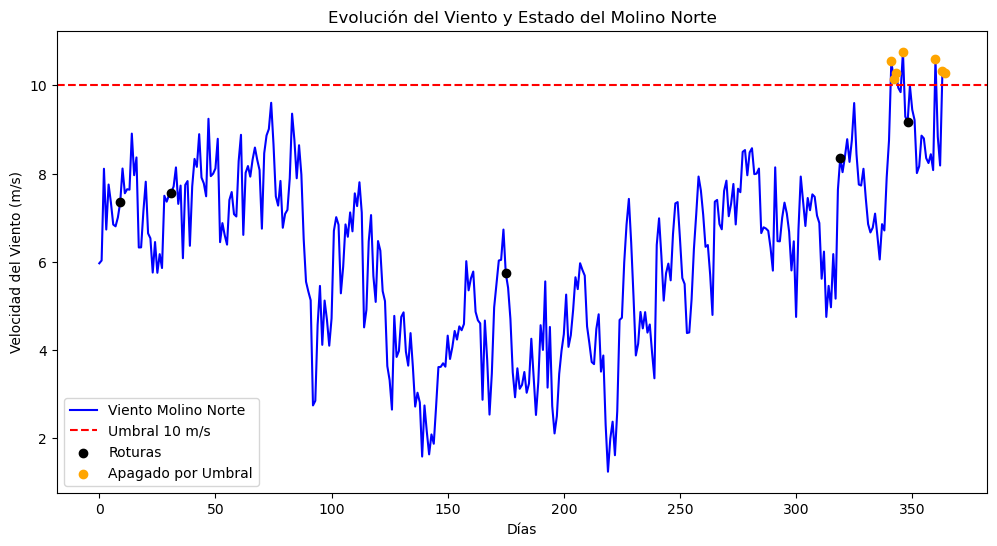

In [241]:
# Días
dias = np.arange(365)
s_norte = S + D/2
s_sur = S - D/2

# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, s_norte, label='Viento Molino Norte', color='blue')

# Umbral de apagado
plt.axhline(10, color='red', linestyle='--', label=f'Umbral {10} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_norte == 1], s_norte[roturas_molino_norte == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(s_norte > 10) & (estado_molino_norte == 0)], s_norte[(s_norte > 10) & (estado_molino_norte == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Norte')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


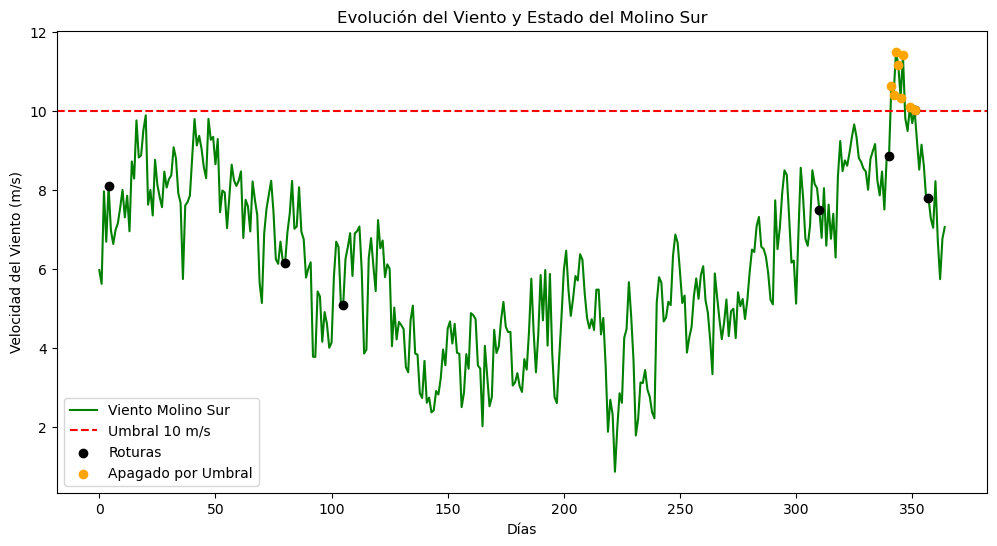

In [242]:
# Gráfico del viento simulado y umbral
plt.figure(figsize=(12, 6))

# Viento en el Molino Norte
plt.plot(dias, s_sur, label='Viento Molino Sur', color='green')

# Umbral de apagado
plt.axhline(10, color='red', linestyle='--', label=f'Umbral {10} m/s')

# Marcar días con roturas
plt.scatter(dias[roturas_molino_sur == 1], s_sur[roturas_molino_sur == 1], color='black', label='Roturas', zorder=5)

# Marcar días en los que el molino está apagado
plt.scatter(dias[(s_sur > 10) & (estado_molino_sur == 0)], s_sur[(s_sur > 10) & (estado_molino_sur == 0)], 
            color='orange', label='Apagado por Umbral', zorder=5)

plt.title('Evolución del Viento y Estado del Molino Sur')
plt.xlabel('Días')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend()
plt.show()


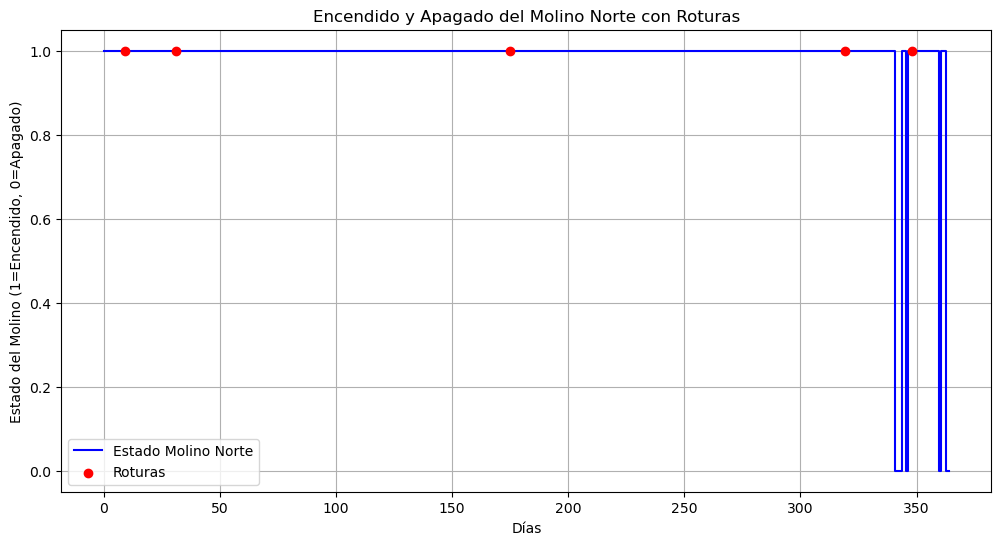

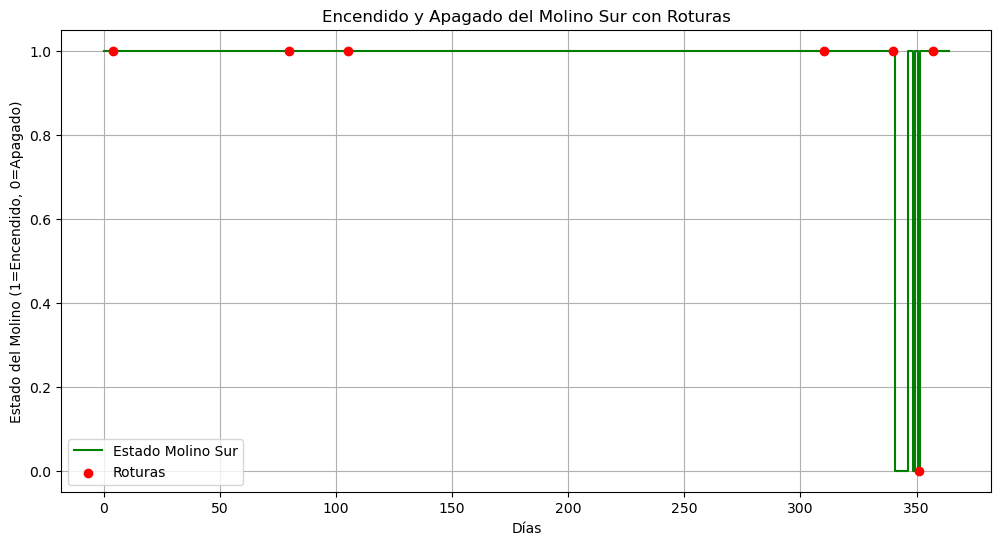

In [243]:
import matplotlib.pyplot as plt

# Días
dias = np.arange(365)

# Gráfico del estado del Molino Norte
plt.figure(figsize=(12, 6))

# Estado del molino Norte (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_norte, label='Estado Molino Norte', color='blue', where='mid')

# Marcar roturas en el molino Norte
plt.scatter(dias[roturas_molino_norte == 1], estado_molino_norte[roturas_molino_norte == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Norte con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()

# Gráfico del estado del Molino Sur
plt.figure(figsize=(12, 6))

# Estado del molino Sur (1=Encendido, 0=Apagado)
plt.step(dias, estado_molino_sur, label='Estado Molino Sur', color='green', where='mid')

# Marcar roturas en el molino Sur
plt.scatter(dias[roturas_molino_sur == 1], estado_molino_sur[roturas_molino_sur == 1], color='red', label='Roturas', zorder=5)

plt.title('Encendido y Apagado del Molino Sur con Roturas')
plt.xlabel('Días')
plt.ylabel('Estado del Molino (1=Encendido, 0=Apagado)')
plt.legend()
plt.grid(True)
plt.show()


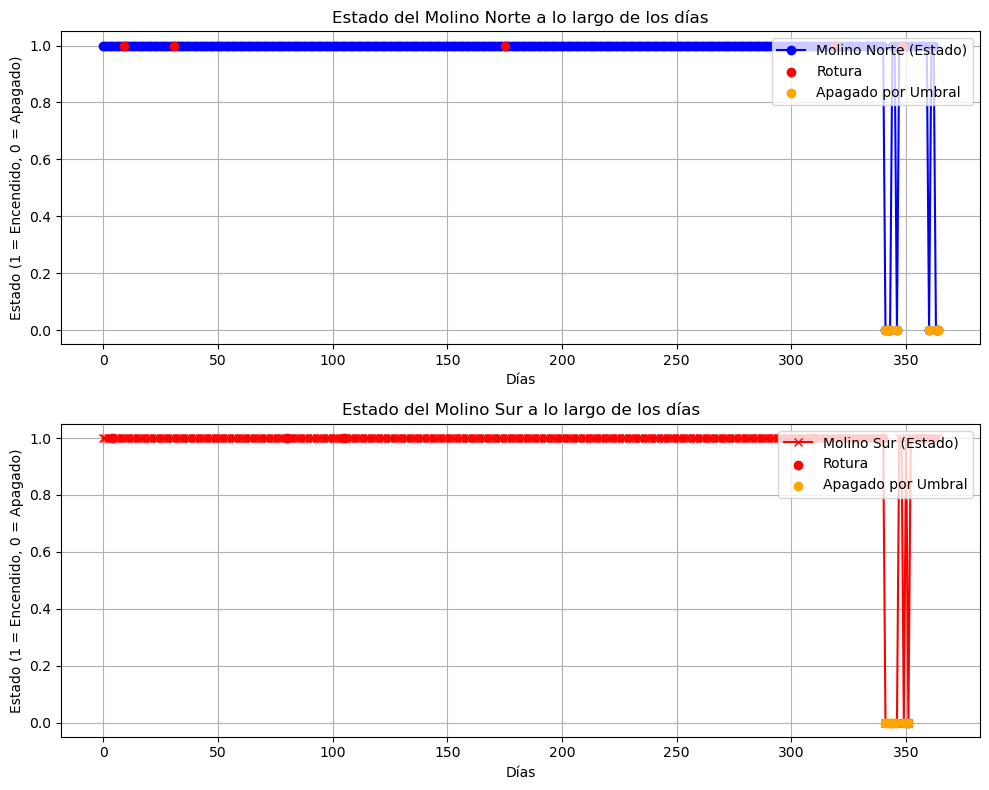

## Ejercicio 5

In [221]:
umbral_k = np.arange(1, 14, 1)
VANs_por_umbral = []
medias_VAN = []
errores_VAN = []
best_van = -np.inf
best_k = None

for k in umbral_k:
    VANs = np.zeros(2000)
    cashflows_simulacion = []  # Lista para almacenar los cashflows de cada simulación con el umbral k
    
    for j in range(2000):
        S, D = simulacion(365)
        VAN, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur, apagados_norte, apagados_sur = calcular_VAN(S, D, k, 365)
        
        VANs[j] = VAN
        cashflows_simulacion.append(cashflow)  # Guardar los cashflows de esta simulación
    

    media_VAN = np.mean(VANs)
    error_VAN = np.std(VANs) / np.sqrt(2000)
    media_cashflow = np.mean(cashflows_simulacion, axis=0)  # Calcular la media de los cashflows de todas las simul
    error_cashflow = np.std(cashflows_simulacion, axis=0) / np.sqrt(2000)  # Calcular el error de los cashflows

    medias_VAN.append(media_VAN)
    errores_VAN.append(error_VAN)

    if media_VAN > best_van:
        best_van = media_VAN
        best_k = k

    VANs_por_umbral.append(VANs)

In [222]:
print('umbral_k:', umbral_k)
print('medias_VAN:', medias_VAN)
print('errores_VAN:', errores_VAN)
print('best_k:', best_k)
print('best_van:', best_van)

umbral_k: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
medias_VAN: [-722550.065687772, -705618.7585046543, -633346.6252352843, -459597.7509112706, -199267.03966439707, 109293.22009687294, 317810.4168323051, 423496.47337263095, 488469.0735618654, 407177.9315961756, 411467.5922418248, 402688.27445187146, 434125.43056698306]
errores_VAN: [1183.6051881549217, 1393.9291971152597, 2577.230369538823, 4711.456991907177, 7637.352264496867, 10480.121214712814, 13434.915523316791, 15836.987695075939, 17454.676148876202, 18470.03316792242, 18874.210065562536, 19149.07038713681, 18875.75617705257]
best_k: 9
best_van: 488469.0735618654


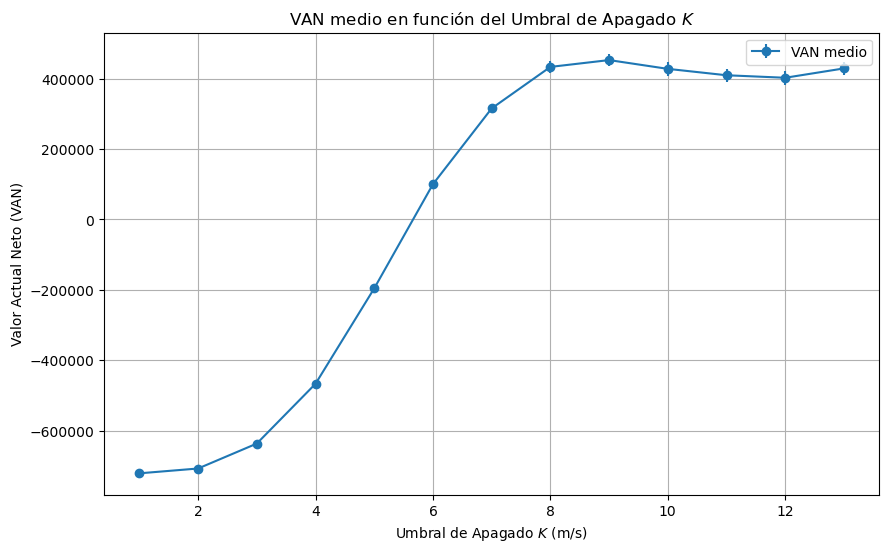

In [186]:
plt.figure(figsize=(10, 6))
plt.errorbar(umbral_k, medias_VAN, yerr=errores_VAN, fmt='-o', label='VAN medio')
plt.title('VAN medio en función del Umbral de Apagado $K$')
plt.xlabel('Umbral de Apagado $K$ (m/s)')
plt.ylabel('Valor Actual Neto (VAN)')
plt.grid(True)
plt.legend()
plt.show()

## Ejercicio 6

In [187]:
print('El valor optimo del umbral es: ', best_k)

El valor optimo del umbral es:  9


## Ejercicio 7

In [188]:
def calcular_VAN_ingenuo(S, D, n_days):
    cashflow = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow[i] -= 200000  # Costo de reparación

        if estado_molino_norte[i] == 1:
            cashflow[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow[i] += 1000 * viento_sur[i]
    
    descuentos = np.exp(-0.05 * np.arange(n_days) / 365)
    VAN = np.sum(cashflow * descuentos)

    return VAN, cashflow, estado_molino_norte, estado_molino_sur, roturas_norte, roturas_sur

In [189]:
VANs_ingenuo = np.zeros(3000)

for i in range(3000):
    S, D = simulacion(365)
    VAN_calculado_ingenuo, cashflow_ingenuo, estado_molino_norte_ingenuo, estado_molino_sur_ingenuo, roturas_molino_norte_ingenuo, roturas_molino_sur_ingenuo = calcular_VAN_ingenuo(S, D, 365)
    VANs_ingenuo[i] = VAN_calculado_ingenuo

media_VAN_ingenuo = np.mean(VANs_ingenuo)
error_VAN_ingenuo = np.std(VANs_ingenuo) / np.sqrt(3000)

In [190]:
print('Ganancia con el umbral optimo: ', best_van)
print('Ganancia ingenua: ', media_VAN_ingenuo)

Ganancia con el umbral optimo:  452896.6404021424
Ganancia ingenua:  421084.8672576075


## Ejercicio 8

Ingresos en Agosto:  2836.123952124371
Error en ingresos en Agosto:  14.781615643647


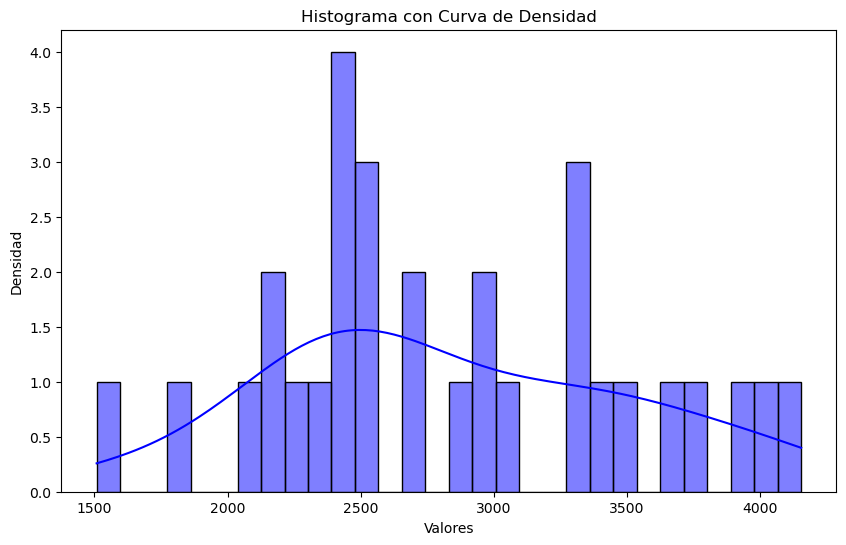

In [203]:
# dias del mes de agosto = 213 al 243
ingresos_agosto = np.zeros(2000)
cashflow_agosto = []

for i in range(213, 243):
    cashflow_agosto.append(media_cashflow[i])

media_cashflows_agosto = np.mean(cashflow_agosto, axis=0)
error_cashflows_agosto = np.std(cashflow_agosto, axis=0) / np.sqrt(2000)

print('Ingresos en Agosto: ', media_cashflows_agosto)
print('Error en ingresos en Agosto: ', error_cashflows_agosto)

import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(cashflow_agosto, kde=True, bins=30, color='blue', alpha=0.5)

# Agregar etiquetas y título
plt.title('Histograma con Curva de Densidad')
plt.xlabel('Valores')
plt.ylabel('Densidad')
plt.show()


## Ejercicio 9

In [ ]:
# Número medio de roturas por año que sufre el molino bajo la estrategia óptima
media_roturas_norte = []
media_roturas_sur = []
for i in range(3650):
    VAN_rot, cashflow_k_rot, estado_molino_norte_rot, estado_molino_sur_rot, roturas_molino_norte_rot, roturas_molino_sur_rot, apagados_molino_norte_rot, apagados_molino_sur_rot = calcular_VAN(S, D, best_k, 365, 200000)
    roturas_i_norte = np.sum(roturas_molino_norte_rot)
    roturas_i_sur = np.sum(roturas_molino_sur_rot)
    media_roturas_norte.append(roturas_i_norte)
    media_roturas_sur.append(roturas_i_sur)
calculo_media_norte = np.mean(media_roturas_norte)
calculo_media_sur = np.mean(media_roturas_sur)
print ('Número Medio de Roturas del Molino Norte bajo estrategia óptima: ', calculo_media_norte)
print ('Número Medio de Roturas del Molino Sur bajo estrategia óptima: ', calculo_media_sur)

In [ ]:
media_roturas_norte_apa = []
media_roturas_sur_apa = []
for i in range(3650):
    VANroto, cashflow_kroto, estado_molino_norteroto, estado_molino_surroto, roturas_molino_norteroto, roturas_molino_surroto, apagados_molino_norteroto, apagados_molino_surroto = calcular_VAN_ingenuo(S, D, 365)
    roturas_i_norte_apa = np.sum(roturas_molino_norteroto)
    roturas_i_sur_apa = np.sum(roturas_molino_surroto)
    media_roturas_norte_apa.append(roturas_i_norte_apa)
    media_roturas_sur_apa.append(roturas_i_sur_apa)
calculo_media_norte_apa = np.mean(media_roturas_norte_apa)
calculo_media_sur_apa = np.mean(media_roturas_sur_apa)

print ('Número Medio de Roturas del Molino Norte sin apagarlo nunca: ', calculo_media_norte_apa)
print ('Número Medio de Roturas del Molino Sur sin apagarlo nunca: ', calculo_media_sur_apa)

## Ejercicio 10

In [ ]:
total_inactivo_norte = 0
total_inactivo_sur = 0

for i in range(3650):
    VAN_inactivo, cashflow_inactivo, estado_molino_norte_inactivo, estado_molino_sur_inactivo, roturas_molino_norte_inactivo, roturas_molino_sur_inactivo, apagados_molino_norte_inactivo, apagados_molino_sur_inactivo=calcular_VAN(S, D, best_k, 365, 200000)
    total_inactivo_norte = np.sum(roturas_molino_norte_inactivo) + np.sum(apagados_molino_norte_inactivo)
    total_inactivo_sur = np.sum(roturas_molino_sur_inactivo) + np.sum(apagados_molino_sur_inactivo)

promedio_inactivo_norte = np.mean(total_inactivo_norte)
promedio_inactivo_sur = np.mean(total_inactivo_sur)
print('Numero de dias promedio por año de inactividad del molino norte',promedio_inactivo_norte)
print('Numero de dias promedio por año de inactividad del molino sur',promedio_inactivo_sur)

## Ejercicio 11

In [218]:
rotura_norte_190 = 0
rotura_sur_190 = 0

for i in range(1000):
    S, D = simulacion(365)
    VAN_calculado, cashflow, estado_molino_norte, estado_molino_sur, roturas_molino_norte, roturas_molino_sur, apagados_molino_norte, apagados_molino_sur = calcular_VAN(S, D, best_k, 365)
    rotura_norte_190 += roturas_molino_norte[190]
    rotura_sur_190 += roturas_molino_sur[190]

proba_rotura_norte = rotura_norte_190 / 1000
proba_rotura_sur = rotura_sur_190 / 1000

proba_rotura_ambos = proba_rotura_norte * proba_rotura_sur

print('Número de roturas en el molino norte en el día 190: ', rotura_norte_190)
print('Número de roturas en el molino sur en el día 190: ', rotura_sur_190)
print('Probabilidad de rotura en el molino norte en el día 190: ', proba_rotura_norte)
print('Probabilidad de rotura en el molino sur en el día 190: ', proba_rotura_sur)

print('Probabilidad de rotura en ambos molinos en el día 190: ', proba_rotura_ambos)



Número de roturas en el molino norte en el día 190:  15.0
Número de roturas en el molino sur en el día 190:  9.0
Probabilidad de rotura en el molino norte en el día 190:  0.015
Probabilidad de rotura en el molino sur en el día 190:  0.009
Probabilidad de rotura en ambos molinos en el día 190:  0.00013499999999999997


## Ejercicio 12

In [204]:
def ingreso_por_molino(S, D, n_days):
    cashflow_norte = np.zeros(n_days)
    cashflow_sur = np.zeros(n_days)

    viento_norte = S + D/2
    viento_sur = S - D/2

    estado_molino_norte = np.ones(n_days)  # 1 = Encendido, 0 = Apagado
    estado_molino_sur = np.ones(n_days)  # 1 = Encendido, 0 = Apagado

    roturas_norte = np.zeros(n_days)
    roturas_sur = np.zeros(n_days)

    apagados_norte = np.zeros(n_days)
    apagados_sur = np.zeros(n_days)

    for i in range(1, n_days):
        if estado_molino_norte[i-1] == 1:
            prob_rotura_norte = 0.25 * (viento_norte[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_norte:
                estado_molino_norte[i] = 0  # Molino roto
                roturas_norte[i] = 1
                cashflow_norte[i] -= 200000  # Costo de reparación

        if estado_molino_sur[i-1] == 1:
            prob_rotura_sur = 0.25 * (viento_sur[i]**2) * (1/365)
            if np.random.rand() < prob_rotura_sur:
                estado_molino_sur[i] = 0  # Molino roto
                roturas_sur[i] = 1
                cashflow_sur[i] -= 200000  # Costo de reparación

        if viento_norte[i] > k:
            estado_molino_norte[i] = 0 #si pasa umbral se apaga
            apagados_norte[i] = 1
            cashflow_norte[i] -= 1000  # Costo de apagar el molino
        elif  viento_norte[i] <= k:
            estado_molino_norte[i] = 1 #si esta por debajo de umbral se enciende

        if viento_sur[i] > k:
            estado_molino_sur[i] = 0
            apagados_sur[i] = 1
            cashflow_sur[i] -= 1000  # Costo de apagar el molino
        elif viento_sur[i] <= k:
            estado_molino_sur[i] = 1

        if estado_molino_norte[i] == 1:
            cashflow_norte[i] += 1000 * viento_norte[i]
        
        if estado_molino_sur[i] == 1:
            cashflow_sur[i] += 1000 * viento_sur[i]

    return cashflow_norte, cashflow_sur

In [205]:
cashflows_norte = []
cashflows_sur = []

for i in range(1000):
    S, D = simulacion(365)
    cashflow_norte, cashflow_sur = ingreso_por_molino(S, D, 365)
    cashflows_norte.append(cashflow_norte)
    cashflows_sur.append(cashflow_sur)

media_cashflows_norte = np.mean(cashflows_norte, axis=0)
error_cashflows_norte = np.std(cashflows_norte, axis=0) / np.sqrt(1000)

media_cashflows_sur = np.mean(cashflows_sur, axis=0)
error_cashflows_sur = np.std(cashflows_sur, axis=0) / np.sqrt(1000)

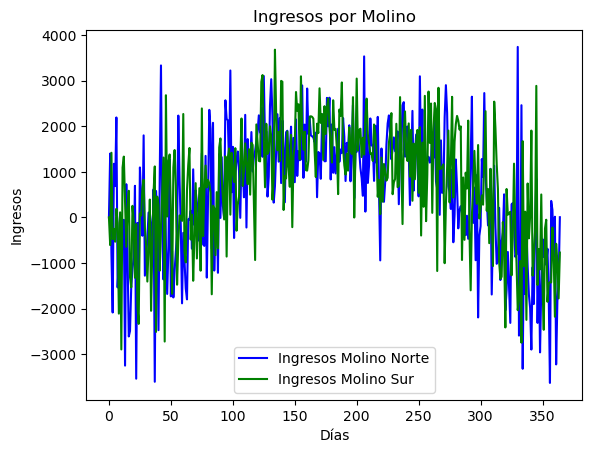

In [210]:
plt.plot(media_cashflows_norte, label='Ingresos Molino Norte', color='blue')
#plt.fill_between(np.arange(365), media_cashflows_norte - error_cashflows_norte, media_cashflows_norte + error_cashflows_norte, color='blue', alpha=0.2)
plt.plot(media_cashflows_sur, label='Ingresos Molino Sur', color='green')
#plt.fill_between(np.arange(365), media_cashflows_sur - error_cashflows_sur, media_cashflows_sur + error_cashflows_sur, color='green', alpha=0.2)
plt.title('Ingresos por Molino')
plt.xlabel('Días')
plt.ylabel('Ingresos')
plt.legend()
plt.show()


In [212]:
correlacion = np.corrcoef(cashflows_norte, cashflows_sur)[0, 1]
print(correlacion)

-0.028997599663483337


A corto plazo, no pareciera haber una correlación. Pero a largo plazo si existe una correlacion, en la cual ambas suben  medida que avanzan los dias hasta alcanzar un pico en la mitad de año aproximadamente, donde pasa a decrecer a medida que avanzan los dias

## Ejercicio 13

In [ ]:
costo_rep = np.arange(100000, 300000, 10000)

# Calcular el VAN para diferentes umbrales
resultados = {}
for j in costo_rep:
    VAN, _, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, j)
    resultados[j] = VAN
print(resultados)

In [ ]:
costo_rep = np.arange(100000, 300000, 10000)

# Calcular el VAN para diferentes umbrales
resultados = {}
for j in costo_rep:
    VAN, _, _, _, _, _, _, _ = calcular_VAN(S, D, best_k, 365, j)
    resultados[j] = VAN
print(resultados)

In [ ]:
umbral_k_2 = np.arange(1, 14, 1)
#costo_reparacion = 250000
best_k_2, best_van_2, medias_VAN_2, errores_VAN_2, VANs_por_umbral_2 = calcular_umbral_optimo(umbral_k, 2000, 250000)
print('umbral_k:', umbral_k_2)
print('medias_VAN:', medias_VAN_2)
print('errores_VAN:', errores_VAN_2)
print('best_k:', best_k_2)
print('best_van:', best_van_2)